## Bitcoin Analysis and Visualization with Plotly, Price Prediction with Keras

### Context

Bitcoin is the longest running and most well known cryptocurrency, first released as open source in 2009 by the anonymous Satoshi Nakamoto. Bitcoin serves as a decentralized medium of digital exchange, with transactions verified and recorded in a public distributed ledger (the blockchain) without the need for a trusted record keeping authority or central intermediary. Transaction blocks contain a SHA-256 cryptographic hash of previous transaction blocks, and are thus "chained" together, serving as an immutable record of all transactions that have ever occurred. As with any currency/commodity on the market, bitcoin trading and financial instruments soon followed public adoption of bitcoin and continue to grow. Included here is historical bitcoin market data at 1-min intervals for select bitcoin exchanges where trading takes place.

<p><img src="bit_image.jpg" style="width:500px"></p>

### Datasets
- coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv
- bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv

CSV files for select bitcoin exchanges for the time period of Jan 2012 to August 2019, with minute to minute updates of OHLC (Open, High, Low, Close), Volume in BTC and indicated currency, and weighted bitcoin price. Timestamps are in Unix time. Timestamps without any trades or activity have their data fields filled with NaNs. If a timestamp is missing, or if there are jumps, this may be because the exchange (or its API) was down, the exchange (or its API) did not exist, or some other unforseen technical error in data reporting or gathering. All effort has been made to deduplicate entries and verify the contents are correct and complete to the best of my ability, but obviously trust at your own risk.

Explanation of the columns:
- Timestamp: Start time of time window (60s window), in Unix time
- OpenOpen: price at start time window
- High: High price within time window
- Low: Low price within time window
- Close: Close price at end of time window
- Volume_(BTC): Amount of BTC transacted in time window
- Volume_(Currency): Amount of Currency transacted in time window
- Weighted_Price: Volume-Weighted Average Price price (VWAP)

In [1]:
import time
start_time=time.time()
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)
plt.rcParams['figure.figsize']=(12,5)
import numpy as np
import operator
import pandas as pd 

In [2]:
# read csv files
df_bitstamp = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv')
df_coinbase = pd.read_csv('coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv')

In [3]:
df_bitstamp.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_bitstamp.shape

(3997697, 8)

In [5]:
df_coinbase.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_coinbase.shape

(2099760, 8)

In [7]:
datetime = pd.to_datetime(df_bitstamp['Timestamp'])

In [8]:
# Convert Timestamp from unix 1 
df_bitstamp = pd.concat([df_bitstamp.drop('Timestamp', axis=1),
                         pd.DataFrame(pd.to_datetime(df_bitstamp['Timestamp'], unit='s'))], axis=1)

In [9]:
df_bitstamp.index = df_bitstamp.Timestamp

In [10]:
# Convert Timestamp from unix 2
df_coinbase = pd.concat([df_coinbase.drop('Timestamp', axis=1), 
                         pd.DataFrame(pd.to_datetime(df_coinbase['Timestamp'], unit='s'))], axis=1)

In [11]:
df_coinbase.index = df_coinbase.Timestamp

### Check the number of null

In [12]:
# Create dataframes that hold missing values
bitstamp_missing = df_bitstamp.isnull().mean()*100
coinbase_missing = df_coinbase.isnull().mean()*100

In [13]:
# import graph objects as "go"
import plotly.graph_objs as go
from plotly import subplots

# Draw graphes
trace0 = go.Bar(x = bitstamp_missing.index,
               y = bitstamp_missing,
               marker = dict(color = 'rgba(245, 140, 130, 0.5)',
               line=dict(color='rgb(0,0,0)',width=1.5)))

trace1 = go.Bar(x = coinbase_missing.index,
               y = coinbase_missing,
               marker = dict(color = 'rgba(130, 135, 245, 0.5)',
               line=dict(color='rgb(0,0,0)',width=1.5)))

fig = subplots.make_subplots(rows=1, cols=2,subplot_titles=("bitstamp dataframe","coinbase dataframe"))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(height=400, width=800, title='Null Percentages')
iplot(fig);

It seems columns except Timestamp missing values at the same rows.

In [14]:
# Since the timestamp is not empty, we fill missing value with ffill method
df_bitstamp['Open'].fillna(method='ffill', inplace=True)
df_bitstamp['High'].fillna(method='ffill', inplace=True)
df_bitstamp['Low'].fillna(method='ffill', inplace=True)
df_bitstamp['Close'].fillna(method='ffill', inplace=True)
df_bitstamp['Volume_(BTC)'].fillna(method='ffill', inplace=True)
df_bitstamp['Volume_(Currency)'].fillna(method='ffill', inplace=True)
df_bitstamp['Weighted_Price'].fillna(method='ffill', inplace=True)

df_coinbase['Open'].fillna(method='ffill', inplace=True)
df_coinbase['High'].fillna(method='ffill', inplace=True)
df_coinbase['Low'].fillna(method='ffill', inplace=True)
df_coinbase['Close'].fillna(method='ffill', inplace=True)
df_coinbase['Volume_(BTC)'].fillna(method='ffill', inplace=True)
df_coinbase['Volume_(Currency)'].fillna(method='ffill', inplace=True)
df_coinbase['Weighted_Price'].fillna(method='ffill', inplace=True)

### Price change with timeseries

/Users/Rory/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



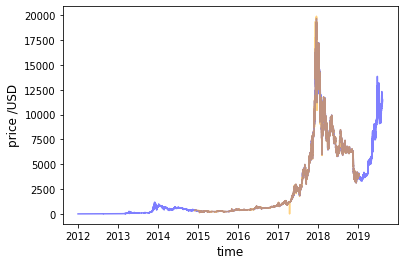

In [15]:
# draw
plt.plot(df_bitstamp.index, df_bitstamp.Weighted_Price, alpha=0.5, color='blue')
plt.plot(df_coinbase.index, df_coinbase.Weighted_Price, alpha=0.5, color='orange')
plt.xlabel('time', fontsize=12)
plt.ylabel('price /USD', fontsize=12);

- coinbase data is missing during before 2015 and after 2019
- There was a peak in price between late 2017 and middle of 2018

bitstamp data seems to have more comprehensive data, so I'll be using only bitstamp data for further analysis

### More insights on bitstamp data

In [16]:
# change timeseries to monthly and weekly
df_bitstamp_m = df_bitstamp.resample('M').mean()
df_bitstamp_w = df_bitstamp.resample('W').mean()

In [17]:
trace_week = go.Scatter(x = df_bitstamp_w.index,
                   y = df_bitstamp_w.Weighted_Price,
                   mode = "lines",
                   name = "Weekly",
                   marker = dict(color = 'rgba(235, 115, 150, 0.8)')
                       )
trace_month = go.Scatter(x = df_bitstamp_m.index,
                   y = df_bitstamp_m.Weighted_Price,
                   mode = "lines",
                   name = "Monthly",
                   marker = dict(color = 'rgba(115, 120, 235, 0.8)')
                       )

data_2 = [trace_week, trace_month]


updatemenus = list([
    dict(active=-1,
         buttons=list([
            dict(label = 'Weekly',
                 method = 'update',
                 args = [{'visible': [True, False]}
                         ]),
            dict(label = 'Monthly',
                 method = 'update',
                 args = [{'visible': [False, True]}
                         ]),
            dict(label = 'Reset',
                 method = 'update',
                 args = [{'visible': [True, True]}])
         ]),
         x = 1.3, y = 1),
])

layout_2 = go.Layout(height=400, width=550, showlegend=False,
                title='Weekly/Monthly Volume-Weighted Average Price', 
                xaxis_title="timestamp",
                yaxis_title="VWAP /USD",
                updatemenus=updatemenus)

fig = dict(data = data_2, layout = layout_2)
iplot(fig);

In [18]:
# Other data
trace_btc = go.Scatter(x = df_bitstamp_m.index,
                   y = df_bitstamp_w['Volume_(BTC)'],
                   mode = "lines",
                   name = "Volume_(BTC)",
                   marker = dict(color = 'rgba(235, 115, 150, 0.8)')
                       )
trace_currency = go.Scatter(x = df_bitstamp_m.index,
                   y = df_bitstamp_m['Volume_(Currency)'],
                   mode = "lines",
                   name = "Volume_(Currency)",
                   marker = dict(color = 'rgba(115, 120, 235, 0.8)')
                       )
trace_weighted_price = go.Scatter(x = df_bitstamp_m.index,
                   y = df_bitstamp_m['Weighted_Price'],
                   mode = "lines",
                   name = "Weighted_Price",
                   marker = dict(color = 'rgba(245, 170, 60, 0.8)')
                       )

fig = subplots.make_subplots(rows=3, cols=1,
                             subplot_titles=("Volume_(BTC)","Volume_(Currency)", "Weighted_Price"))

fig.append_trace(trace_btc, 1, 1)
fig.append_trace(trace_currency, 2, 1)
fig.append_trace(trace_weighted_price, 3, 1)

fig['layout'].update(height=650, width=750, showlegend=False)

iplot(fig);

### Seasonal Trend Decomposition

<Figure size 1224x864 with 0 Axes>

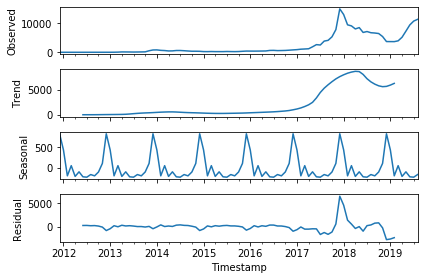

In [20]:
# define seasonal trend decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose(series):
    plt.figure(figsize = (17,12))
    seasonal_decompose(series).plot()
    plt.show()

decompose(df_bitstamp_m.Weighted_Price)

### Price prediction

- In progress

### Acknowledgements and Inspiration
Bitcoin charts for the data. The various exchange APIs, for making it difficult or unintuitive enough to get OHLC and volume data at 1-min intervals that I set out on this data scraping project. Satoshi Nakamoto and the novel core concept of the blockchain, as well as its first execution via the bitcoin protocol. I'd also like to thank viewers like you! Can't wait to see what code or insights you all have to share.